In [1]:
from IPython.core.display import HTML
import urllib.request
HTML(urllib.request.urlopen('http://bit.ly/1Bf5Hft').read().decode('utf-8'))

In [2]:
import pandas as pd 
import numpy as np

# Survival analysis
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from lifelines import KaplanMeierFitter

# Sentiment analysis
from textblob import TextBlob

# Serialization
import pickle

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# Supress warnings
import warnings; warnings.simplefilter('ignore')


In [3]:
df = pd.read_csv('agg_data/combined_data_survival.csv') 

#### Table of contents


##### [Introduction](#introduction)

##### [Survival analysis](#survival)

##### [Pre-processing](#process)

##### [Training, Validation and Testing](#training)

##### [Conclusion](#conclusion)


### Introduction <a id='introduction'></a>


Previously, we looked at loan default from a binary classification perspective. The idea was to increase returns by avoiding 
loans which will default. However this does not give a complete picture. A high interest loan which defaults closert to maturity will have higher returns than a low interest loan which defaults earlier. Binary classification will bin both of these loans together. Moreover binary classfication only considers completed loans, loans whose eventual outcome is unknown can't be considered under supervised classification. 
<br>
<br>
A better approach would be to model the time to default. This will allow us to get a sense of *when* a loan is likely to
default. Survival analysis provides us with tools to model a time to death of an organism or a failure
of a mechanical system. The concepts of survival analysis can be successfully used in many
different situations, e.g. observing time until formal convicts, after having been released,
commits a crime again. We can fit this framework into the credit risk branch, where we observe
a time to default of a borrower.

### Survival analysis <a id='survival'></a>

We consider methods for the analysis of data which model the time when a specific event
occurs. Because we use survival analysis concepts, we
assume that each client will face default at some point in the future. 
<br>
<br>
Let $X$ be a nonnegative random variable representing the time of default of a borrower,
suppose that $X$ has a distribution function $F$ and a density function $f$. The distribution of
$X$ can be specified in many ways of which commonly used is  a hazard function, conventionally
denoted by $\lambda(.)$ , which is defined as
<br>
<br>
$$\lambda(t) = \lim_{h \to 0} P(t\leq X < t +h \;\;| X \geq t)$$
<br>
A hazard function fully specifies the distribution of $X$. If we define the survival function $S(t)$ by  $S(t) = 1 − F(t)$,
then we can rewrite the hazard function as $\lambda(t) = (-\log (S(t))^{'}$
<br>
<br>
#### Censored data

We observe data from $n$ borrowers. We do not usually have complete information about our
borrower -whether she had defaulted or not- simply because we can only observe her during a
fixed time interval of length T. During this interval there are three possibilities of a borrower
status to be observed: default at time X, no default until time T or a customer leaving the
survey at time C before the final status could have been obtained. For this project, we consider the so-called 'right censoring'.
<br>
<br>
#### Models

There are several approaches to obtain the survival function from data. The most elementary
and straight forward way is to calculate the survival function using the Kaplan-Meier
estimator. Here we use slightly more advanced models based on an a priori knowledge of the
form of a hazard function and borrowers characteristics as covariates. In the following, $Z_i$ denotes a vector of $p$ covariates for the client $i$ and β denotes the
p- dimensional vector of unknown parameters.

##### Cox model

Assume that covariates have a multiplicative effect on the hazard, specifically we speak
about proportional hazards models. These models are often called Cox models, inspired by
Cox (1972). He assumed that the hazard function has a form
<br>
<br>
$$\lambda(t_i, Z_i) = \lambda_{0}(t)exp(Z_{i}^{'}\beta)$$
<br>
where β is a p×1 vector of unknown parameters, $Z_i$ are given covariates and $\lambda_{0}(t)$ is a baseline
hazard function. We can interpret a baseline hazard as a hazard when all covariates are set
to zero. *In Cox model, the ratio of two borrowers obviously does not depend on the baseline
function*. 
<br>
<br>
If we consider clients with covariates $Z_1$ and $Z_2$, the proportion of their hazard
functions,
<br>
<br>
$$\frac{\lambda(t, Z_1)}{\lambda(t, Z_2)} = exp((Z_1 - Z_2)^{'}\beta),$$
<br>
is a function of their characteristics, which does not depend on the parameter t. This is a crucial assumption of the Cox proportional hazard model. (There are other time dependent hazard models, but for this project we will only use the time independent version!)


### Data pre-processing  <a id='process'></a>

Since the way we pre-process the data is slightly different compared to the classification models, we will go through the pre-processing steps separately here. Note that the data only consists of 36 month loans.
<br>
<br>
First let us drop any columns which won't be of any predictive power.

In [4]:
df.drop(['Unnamed: 0', 'V1'], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306482 entries, 0 to 306481
Columns: 142 entries, loan_amnt to status
dtypes: bool(1), float64(94), int64(17), object(30)
memory usage: 330.0+ MB


In [6]:
half_ct = len(df)/2
df.dropna(axis='columns', thresh=half_ct, inplace=True)

These columns have lots of null values. The features mostly tie in to the credit history of the borrower. These features will not have much predictive power in classfication algorithms, since the internal credit rating for Lending club will take all these factors in to account when assigning a loan grade. 


In [7]:
credit_lots_of_null = ['mo_sin_old_il_acct',
'mo_sin_old_rev_tl_op',
'mo_sin_rcnt_rev_tl_op',
'mo_sin_rcnt_tl',
'mort_acc',
'mths_since_recent_bc',
'mths_since_recent_inq',
'num_accts_ever_120_pd',
'num_actv_bc_tl',
'num_actv_rev_tl',
'num_bc_sats',
'num_bc_tl',
'num_il_tl',
'num_op_rev_tl',
'num_rev_accts',
'num_rev_tl_bal_gt_0',
'num_sats',
'num_tl_120dpd_2m',
'num_tl_30dpd',
'num_tl_90g_dpd_24m',
'num_tl_op_past_12m',
'pct_tl_nvr_dlq',
'percent_bc_gt_75',
'tot_coll_amt',
'tot_cur_bal',
'total_rev_hi_lim',
'acc_open_past_24mths',
'avg_cur_bal',
'bc_open_to_buy',
'bc_util', 
'tot_hi_cred_lim',
'total_bal_ex_mort',
'total_bc_limit',
'total_il_high_credit_limit']

In [8]:
df.drop(credit_lots_of_null, axis=1, inplace=True)

In [9]:
# Let's convert revoling utlties to float and fill in the remaining values
df["revol_util"] = df["revol_util"].str.replace('%','')
df["revol_util"] = df["revol_util"].astype(float)

In [10]:
df["revol_util"].fillna(df["revol_util"].median(), inplace=True)

In [11]:
# Lets fill in the remaining values for employment length 
df["emp_length"].fillna(df["emp_length"].median(), inplace=True)

These features are not useful co-variates. Either they mostly take a single value (`collections_12_mths_ex_md`, `poliy_code`, `application_type`) or other features already incorporate their information. Let's drop these columns

In [12]:
df.drop(['last_pymnt_d',
'last_pymnt_amnt',
'last_credit_pull_d',
'collections_12_mths_ex_med',
'policy_code',
'application_type'], axis=1, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306482 entries, 0 to 306481
Data columns (total 48 columns):
loan_amnt                   306482 non-null int64
funded_amnt                 306482 non-null int64
funded_amnt_inv             306482 non-null float64
term                        306482 non-null int64
int_rate                    306482 non-null float64
installment                 306482 non-null float64
grade                       306482 non-null object
sub_grade                   306482 non-null object
emp_length                  306482 non-null float64
home_ownership              306482 non-null object
annual_inc                  306482 non-null float64
verification_status         306482 non-null object
issue_d                     306482 non-null object
loan_status                 306482 non-null object
pymnt_plan                  306482 non-null object
purpose                     306482 non-null object
title                       306477 non-null object
zip_code            

Let's now turn our attention to the loan title. Let's generate new features from the title. 
Before that, let's fill in the remaining nan's in titles.

In [14]:
df['title'] = df['title'].replace(np.nan, '')

Let's create a dataframe of title polarity and sentiment 

In [15]:
df_polsub = df['title'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment)) # Sentiment returns a dataframe of the form 
                                                                                # (polarity, subjectivity).

In [16]:
def count_words(text):
    return len(text.split())

In [17]:
df['title_word_count'] = df['title'].apply(count_words)

In [18]:
df['title_polarity'] = df_polsub[0]

In [19]:
df['title_subjectivity'] = df_polsub[1]

In [20]:
df['title_length'] = df['title'].apply(len)

In [21]:
df['lti'] = df.loan_amnt/ df.annual_inc

Let us now drop features which are not really needed since they don't have much predictive power.

In [22]:
df.drop(['title', 
         'zip_code', 
         'addr_state',
         'loan_status',
         'total_acc',
         'acc_now_delinq',
         'loan_amnt',
         'funded_amnt_inv',
         'pub_rec_bankruptcies',
         'total_pymnt_inv',
         'total_rec_prncp', 
         'total_rec_int',
         'total_rec_late_fee',
         'disbursement_method', 
         'debt_settlement_flag',
         'term',
         'hardship_flag', 
         'collection_recovery_fee',
         'chargeoff_within_12_mths',
         'out_prncp',
         'out_prncp_inv',
         'revol_bal',
         'pymnt_plan'], axis=1, inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306482 entries, 0 to 306481
Data columns (total 30 columns):
funded_amnt            306482 non-null int64
int_rate               306482 non-null float64
installment            306482 non-null float64
grade                  306482 non-null object
sub_grade              306482 non-null object
emp_length             306482 non-null float64
home_ownership         306482 non-null object
annual_inc             306482 non-null float64
verification_status    306482 non-null object
issue_d                306482 non-null object
purpose                306482 non-null object
dti                    306482 non-null float64
delinq_2yrs            306482 non-null int64
inq_last_6mths         306482 non-null int64
open_acc               306482 non-null int64
pub_rec                306482 non-null int64
revol_util             306482 non-null float64
initial_list_status    306482 non-null object
total_pymnt            306482 non-null float64
recoveries   

This finishes the pre-processing for survival analysis. Lets proceed to survival analysis.  

In [24]:
### Copy the dataframe 

df_copy = df.copy()

Let's first try out univariate survival analysis using Kaplan Meier estimates.

##### Kaplan Meier estimates

In [25]:
kmf = KaplanMeierFitter() 

In [26]:
# The 1st arg accepts an array or pd.Series of individual survival times
# The 2nd arg accepts an array or pd.Series that indicates if the event 
# interest (or death) occured.
kmf.fit(durations = df_copy.time, 
        event_observed = df_copy.status)

<lifelines.KaplanMeierFitter: fitted with 306482 observations, 265884 censored>

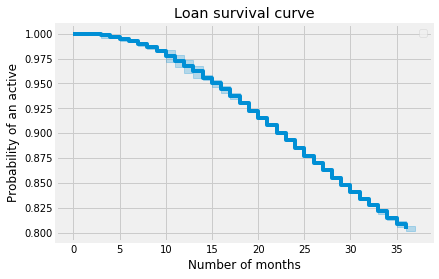

In [27]:
#plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(15, 9))
# plot the KM estimate
kmf.plot()
# Add title and y-axis label
plt.title("Loan survival curve")
plt.ylabel("Probability of an active")
plt.xlabel('Number of months')
plt.legend('')

plt.show()
#plt.savefig("loan_survival_plot.png")

In [28]:
T = df_copy["time"]
E = df_copy["status"]

Text(0,0.5,'Probability of an active loan')

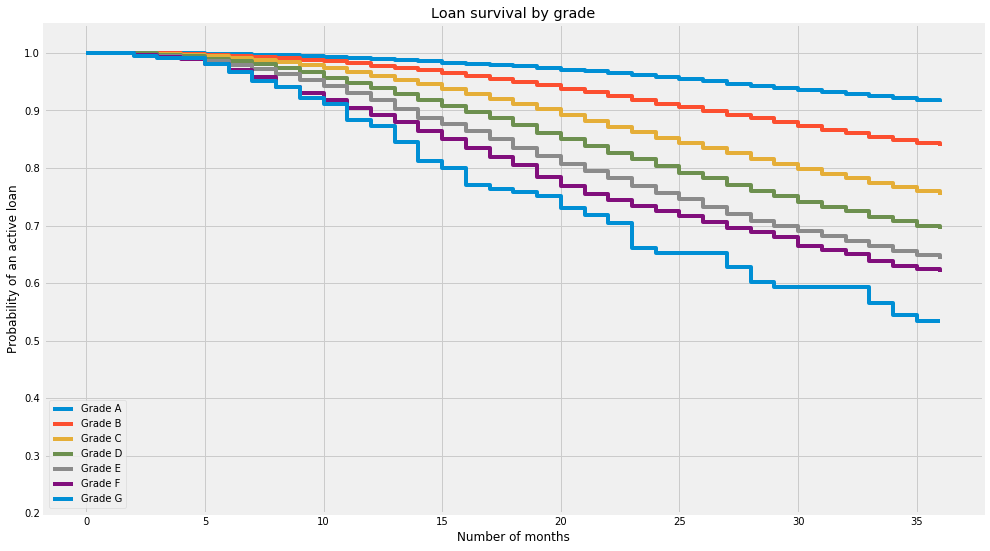

In [29]:
# Plot survival times grouped by loan category 

plt.figure(figsize=(15, 9))
ax = plt.subplot(111)

a = (df_copy["grade"] == "A")
kmf.fit(T[a], event_observed=E[a], label="Grade A")
kmf.plot_survival_function_(ax=ax, ci_force_lines=False, ci_show=False)

b = (df_copy["grade"] == "B")
kmf.fit(T[b], event_observed=E[b], label="Grade B")
kmf.plot(ax=ax, ci_force_lines=False, ci_show=False)

c = (df_copy["grade"] == "C")
kmf.fit(T[c], event_observed=E[c], label="Grade C")
kmf.plot(ax=ax, ci_force_lines=False, ci_show=False)

d = (df_copy["grade"] == "D")
kmf.fit(T[d], event_observed=E[d], label="Grade D")
kmf.plot(ax=ax, ci_force_lines=False, ci_show=False)

e = (df_copy["grade"] == "E")
kmf.fit(T[e], event_observed=E[e], label="Grade E")
kmf.plot(ax=ax, ci_force_lines=True, ci_show=False)

f = (df_copy["grade"] == "F")
kmf.fit(T[f], event_observed=E[f], label="Grade F")
kmf.plot(ax=ax, ci_force_lines=True, ci_show=False)

g = (df_copy["grade"] == "G")
kmf.fit(T[g], event_observed=E[g], label="Grade G")
kmf.plot_survival_function_(ax=ax, ci_force_lines=True, ci_show=False)

plt.ylim(0.2, 1.05);
plt.title("Loan survival by grade")
plt.xlabel('Number of months')
plt.ylabel('Probability of an active loan')
#plt.savefig("loan_survival_plot_by_grade.png")

Text(0,0.5,'Probability of an active loan')

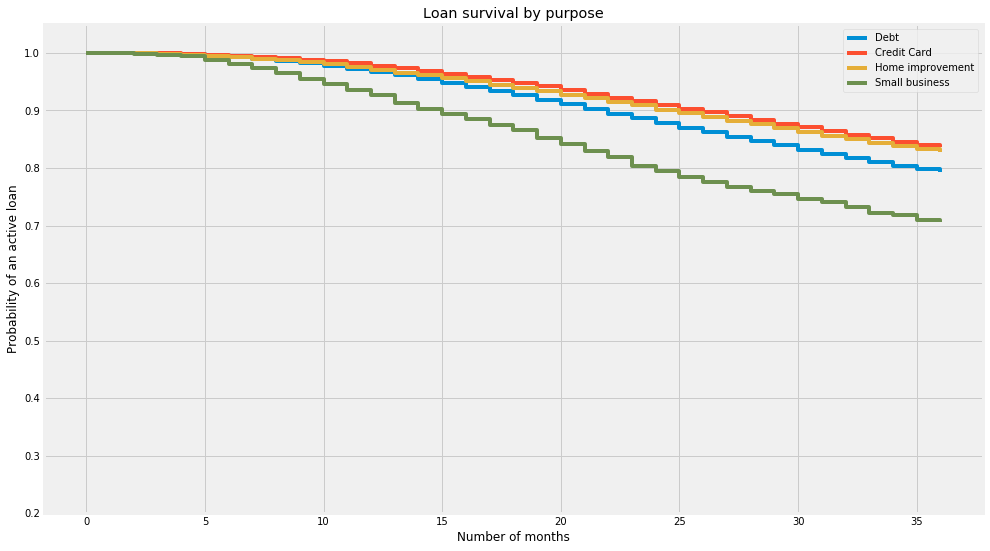

In [30]:
### Plot survival time by loan purpose 
plt.figure(figsize=(15, 9))
ax = plt.subplot(111)

a = (df_copy["purpose"] == "debt_consolidation")
kmf.fit(T[a], event_observed=E[a], label="Debt")
kmf.plot_survival_function_(ax=ax, ci_force_lines=False, ci_show=False)

b = (df_copy["purpose"] == "credit_card")
kmf.fit(T[b], event_observed=E[b], label="Credit Card")
kmf.plot(ax=ax, ci_force_lines=False, ci_show=False)

c = (df_copy["purpose"] == "home_improvement")
kmf.fit(T[c], event_observed=E[c], label="Home improvement")
kmf.plot(ax=ax, ci_force_lines=False, ci_show=False)

d = (df_copy["purpose"] == "small_business")
kmf.fit(T[d], event_observed=E[d], label="Small business")
kmf.plot(ax=ax, ci_force_lines=False, ci_show=False)

plt.ylim(0.2, 1.05);
plt.title("Loan survival by purpose")
plt.xlabel('Number of months')
plt.ylabel('Probability of an active loan')

### Training, Validation & Testing <a id='training'></a>


Instead of a random split, we will split our data date-wise. This is important since we will be testing an investment strategy
on the test data set, and for such purposes a split by date makes more sense. 

In [31]:
test = df_copy[(df_copy["issue_d"] == "Oct-2014") |
                            (df_copy["issue_d"] == "Nov-2014") | (df_copy["issue_d"] == "Dec-2015")]

In [32]:
train = df_copy[~(df_copy["issue_d"] == "Oct-2014") &
                            ~(df_copy["issue_d"] == "Nov-2014") & ~(df_copy["issue_d"] == "Dec-2015")]

In [33]:
train.columns

Index(['funded_amnt', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_util', 'initial_list_status',
       'total_pymnt', 'recoveries', 'delinq_amnt', 'tax_liens', 'credit_age',
       'time', 'status', 'title_word_count', 'title_polarity',
       'title_subjectivity', 'title_length', 'lti'],
      dtype='object')

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263316 entries, 0 to 306461
Data columns (total 30 columns):
funded_amnt            263316 non-null int64
int_rate               263316 non-null float64
installment            263316 non-null float64
grade                  263316 non-null object
sub_grade              263316 non-null object
emp_length             263316 non-null float64
home_ownership         263316 non-null object
annual_inc             263316 non-null float64
verification_status    263316 non-null object
issue_d                263316 non-null object
purpose                263316 non-null object
dti                    263316 non-null float64
delinq_2yrs            263316 non-null int64
inq_last_6mths         263316 non-null int64
open_acc               263316 non-null int64
pub_rec                263316 non-null int64
revol_util             263316 non-null float64
initial_list_status    263316 non-null object
total_pymnt            263316 non-null float64
recoveries   

Let's pay attention to features which leak information from the future (i.e after the loan has been funded). These features won't be available to the lender at the time of origination. We will drop them along with features which no longer have any
predictive power or don't satisfy CPH assumptions

In [35]:
drop_cols = ['total_pymnt',
             'recoveries',
             'issue_d', 
             'home_ownership',
              'sub_grade',
              'funded_amnt'
                ] 

In [36]:
#train.drop(drop_cols, axis=1, inplace=True)
train.drop(drop_cols, axis=1, inplace=True)

In [37]:
test.drop(drop_cols, axis=1, inplace=True) # Do the same for test set too!

Let's convert the non-numeric features to numeric values.

In [38]:
map_grades = {
    "grade":{
        "A": 7,
        "B": 6,
        "C": 5,
        "D": 4,
        "E": 3,
        "F": 2,
        "G": 1
    }
        }
#train = train.replace(map_grades)
train = train.replace(map_grades)

In [39]:
test = test.replace(map_grades)

In [40]:
categorical_vars = ['initial_list_status', 'verification_status', 'purpose']
#train = pd.get_dummies(train, columns=categorical_vars)
train = pd.get_dummies(train, columns=categorical_vars)

In [41]:
test = pd.get_dummies(test, columns=categorical_vars)

We are now ready to train the data using a CPH model

In [42]:
cph_1 = CoxPHFitter()

In [43]:
cph_2 = CoxPHFitter(penalizer=0.01)


In [44]:
print(np.mean(k_fold_cross_validation(cph_1, train, duration_col='time', event_col='status'))) # Ranked by concordance index
print(np.mean(k_fold_cross_validation(cph_2, train, duration_col='time', event_col='status')))

0.6605993084822515
0.6605422262390733


Let us look at a few plots. First up is the feature importance.

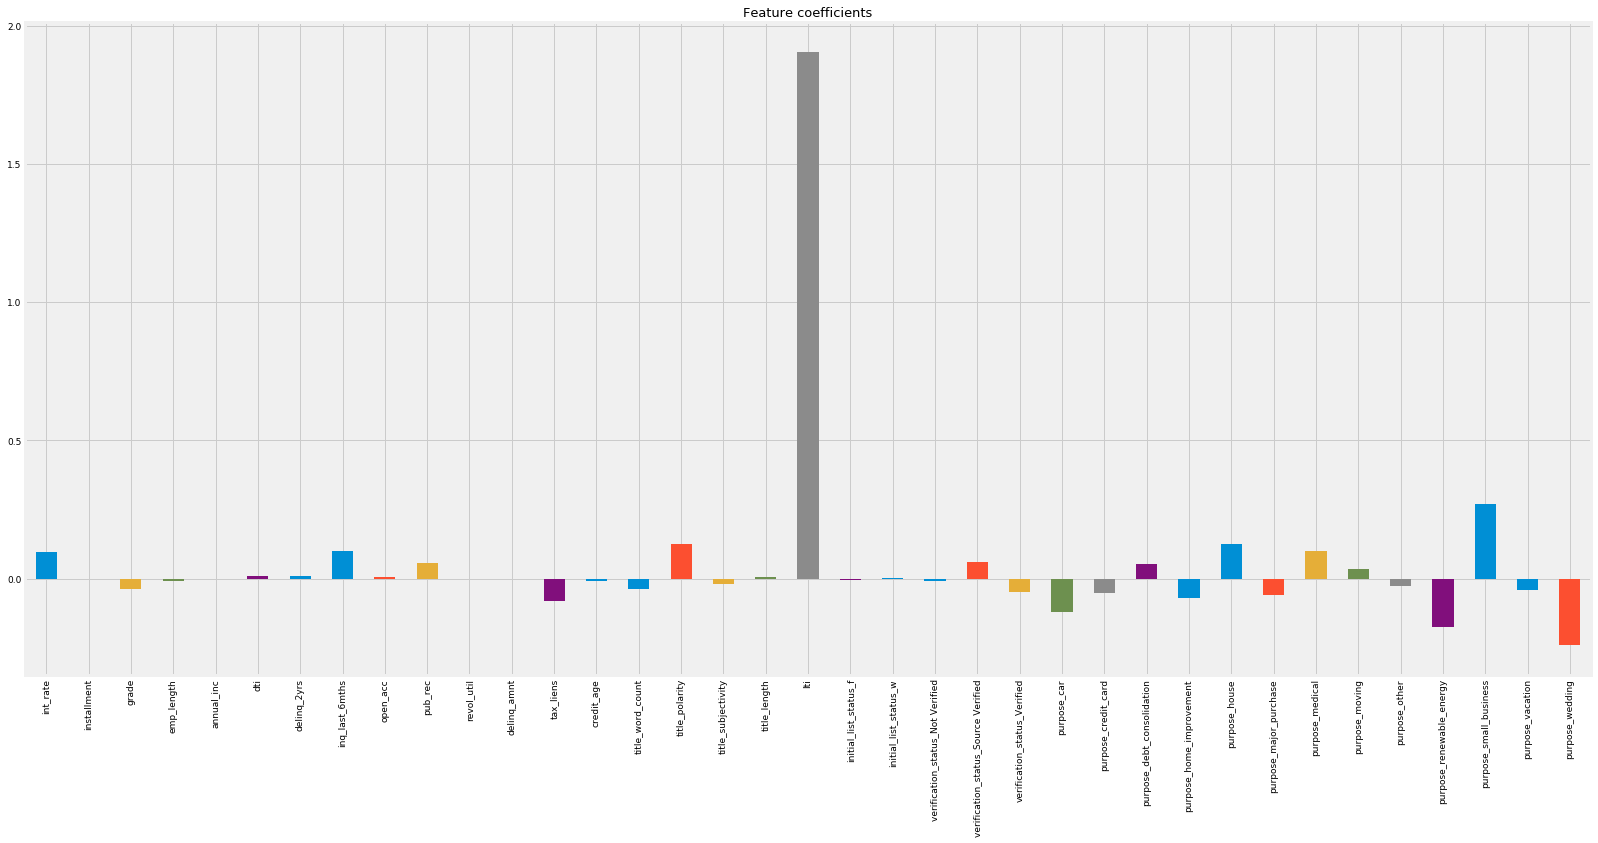

In [45]:
plt.rcParams.update({'font.size': 9})
plt.figure(figsize=(25, 12))
plt.title('Feature coefficients')
cph_2.summary['coef'].plot(kind='bar') # Bar plot of the coefficients
plt.savefig('covariates.png')

In [46]:
cph_2.summary

,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
int_rate,9.710136e-02,1.101972,5.260456e-03,18.458734,4.436189e-76,8.679105e-02,1.074117e-01
installment,-4.205502e-04,0.999580,4.480752e-05,-9.385706,6.249637e-21,-5.083714e-04,-3.327291e-04
grade,-3.590777e-02,0.964729,1.733139e-02,-2.071835,3.828087e-02,-6.987667e-02,-1.938873e-03
emp_length,-1.007489e-02,0.989976,1.792499e-03,-5.620580,1.903173e-08,-1.358812e-02,-6.561652e-03
annual_inc,-2.446666e-07,1.000000,2.431306e-07,-1.006317,3.142629e-01,-7.211939e-07,2.318607e-07
dti,8.623796e-03,1.008661,8.817766e-04,9.780024,1.371775e-22,6.895546e-03,1.035205e-02
delinq_2yrs,9.962214e-03,1.010012,7.327031e-03,1.359652,1.739400e-01,-4.398504e-03,2.432293e-02
inq_last_6mths,9.872109e-02,1.103758,5.734074e-03,17.216571,1.994625e-66,8.748251e-02,1.099597e-01
open_acc,4.551929e-03,1.004562,1.394342e-03,3.264570,1.096302e-03,1.819068e-03,7.284790e-03
pub_rec,5.740063e-02,1.059080,1.551345e-02,3.700055,2.155524e-04,2.699482e-02,8.780643e-02


Clearly, `loan-to-income` affects survival time the most. A few other surprising features are `title polarity`, `tax liens` and 
`purpose_wedding`. The latter two are indicators of repayment. (And hence te corresponding coefficients take negative values.)

In [47]:
cph_2.baseline_survival_ # Baseline survival for a normal loan

,baseline survival
event_at,
0,1.000000
1,0.999868
2,0.999465
3,0.998559
4,0.997354
5,0.995472
6,0.993289
7,0.990719
8,0.987591


In [48]:
X = test.drop(["time", "status"], axis=1)
cph_2.predict_survival_function(X) # Survival function for each loan in the test set 

,149350,149496,149559,149582,149586,149594,149597,149608,149615,149618,...,306472,306473,306474,306475,306476,306477,306478,306479,306480,306481
event_at,,,,,,,,,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999892,0.999953,0.999944,0.999758,0.999948,0.999917,0.999886,0.999708,0.999899,0.999939,...,0.999937,0.999915,0.999889,0.999879,0.999871,0.999918,0.999939,0.999891,0.999929,0.999949
2,0.999559,0.999810,0.999774,0.999019,0.999790,0.999664,0.999536,0.998814,0.999591,0.999754,...,0.999743,0.999653,0.999550,0.999509,0.999476,0.999665,0.999751,0.999559,0.999711,0.999791
3,0.998814,0.999490,0.999390,0.997359,0.999434,0.999095,0.998750,0.996808,0.998900,0.999337,...,0.999307,0.999067,0.998790,0.998678,0.998589,0.999098,0.999329,0.998812,0.999223,0.999438
4,0.997821,0.999062,0.998880,0.995152,0.998959,0.998337,0.997704,0.994142,0.997979,0.998782,...,0.998727,0.998286,0.997777,0.997572,0.997408,0.998343,0.998768,0.997818,0.998572,0.998967
5,0.996270,0.998394,0.998082,0.991710,0.998218,0.997153,0.996070,0.989986,0.996541,0.997915,...,0.997821,0.997065,0.996195,0.995844,0.995565,0.997163,0.997890,0.996266,0.997556,0.998230
6,0.994470,0.997619,0.997155,0.987723,0.997357,0.995778,0.994174,0.985177,0.994872,0.996908,...,0.996769,0.995648,0.994359,0.993840,0.993426,0.995794,0.996871,0.994464,0.996376,0.997375
7,0.992351,0.996704,0.996063,0.983042,0.996343,0.994159,0.991942,0.979535,0.992907,0.995721,...,0.995529,0.993980,0.992198,0.991481,0.990910,0.994181,0.995670,0.992343,0.994985,0.996368
8,0.989770,0.995589,0.994731,0.977355,0.995105,0.992186,0.989223,0.972688,0.990512,0.994274,...,0.994017,0.991946,0.989565,0.988607,0.987845,0.992214,0.994205,0.989759,0.993290,0.995139


In [49]:
# cph_2.predict_survival_function(X)[149608].plot() # Survival curve for a random loan in the test set 

Now that we have the survival probabilities for each test loan, let us compute the expected number of payments. This would be the main metric that decides the time to default. 

In [50]:
test['expected_number_of_payments'] = cph_2.predict_expectation(X)

In [51]:
test['expected_number_of_payments'] = (test['expected_number_of_payments'] + 1).astype(int) # Round off to the next integer

We will now use the expected number of payments to compute the expected return and compare the results with the actual observed
returns. 

In [52]:
test['installment'] = df.iloc[test.index]['installment']
test['funded_amnt'] = df.iloc[test.index]['funded_amnt']
test['total_pymnt'] = df.iloc[test.index]['total_pymnt']

Lets now save this dataframe and use it to compute expected returns. 

In [ ]:
test.to_pickle('agg_data/df_survival.pkl', compression='infer', protocol=4)

### Conclusion <a id='conclusion'></a>

In this analysis, we looked at survival analysis to model time to default. With the probability of default (PD) as a key credit risk parameter, credit risk models typically aim at distinguishing “good” customers from “bad” customers. This is historically done through classification techniques such as decision trees and logistic regression. A disadvantage of these techniques, however, is that they do not take the timing of default into account. When using survival analysis, we are able to predict when customers are likely to default. Not only can this lead to more accurate credit risk calculations, there are some other advantages that will be discussed in what follows.
<br>
<br>
Firstly, survival analysis can deal with censoring. Censoring is central to survival analysis. The basic idea is that information is censored, it is invisible to you. Simply explained, a censored distribution of life times is obtained if you record the life times before everyone in the sample has died. In the credit risk context, censoring occurs when a specific loan is under repayment at the moment of data gathering. At that stage, it is clear that default has not occurred. However, as the loan has not reached the end term yet, we cannot draw final conclusions on whether in the end this particular loan will default or not – or in classification terms, whether we are dealing with a “good” or a “bad” customer. When using traditional classification techniques, it is not possible to include the information regarding this borrower as an input in the model. Focusing on the time aspect of default, censoring can be dealt with when using survival analysis techniques, and information such as “borrower X with characteristics Y has at least been repaying for Z months” can be taken into account. The advantage of not being forced to leave out these censored cases is straightforward: as more information can be included when building a model, one is able to make more accurate predictions when using survival analysis models as opposed to standard classification techniques.
<br>
<br>
Moreover, using expected number of payments allows us to construct an investment strategy. By calculatig the expected rate of return, we can rank all the loans. This way an investor can get access to the top loans. When a new loan comes along, the model parameters can be used to quickly calculate the expected return. 
<br>
<br>
To see how well this strategy performs, we will validate this strategy and compare the expected returns to observed returns.


###### How will we tackle class imbalance in Cox Regression?

Heres an answer from [Stackoverflow](https://stats.stackexchange.com/questions/127028/is-oversampling-done-for-cox-regression-data)
<br>
<br>
*The point of a Cox analysis is not to analyze who dies and who does not die; rather it is to study effects of covariates on the timing of death. A Cox analysis would be valid even if everyone died. The fundamental unit is not the individual but the risk set at each failure time.*
<br>
<br>
*The Cox partial likelihood compares covariate values for the failure and the others in the risk set. So an imbalance is built into the Cox analysis, but it is not a shortage of non-failures, just a reverse: the one (or few) failures at each distinct failure time is compared to all those who have not yet failed by that time.*